In [2]:
using Revise

In [3]:
using OpticalBlochEquations

In [4]:
using Plots
using BenchmarkTools
using DifferentialEquations

In [92]:
const λ = @with_unit 626 "nm"
const Γ = @with_unit 2π * 8 "MHz"
const M = @with_unit 50 "u"
const E₀ = c / λ
;

In [839]:
# Wigner D-matrix to rotate polarization vector
D(cosβ, sinβ, α, γ) = [
    (1/2)*(1 + cosβ)*exp(-im*(α + γ)) -(1/√2)*sinβ*exp(-im*α) (1/2)*(1 - cosβ)*exp(-im*(α - γ));
    (1/√2)*sinβ*exp(-im*γ) cosβ -(1/√2)*sinβ*exp(im*γ);
    (1/2)*(1 - cosβ)*exp(im*(α - γ)) (1/√2)*sinβ*exp(im*α) (1/2)*(1 + cosβ)*exp(im*(α + γ))
];

function rotate_pol(pol, k)
    # Rotates polarization `pol` onto the quantization axis `k`
    cosβ = k[3]
    sinβ = sqrt(1 - cosβ^2)
    α = 0.0
    if abs(cosβ) < 1
        γ = atan(k[2], k[1])
    else
        γ = 0.0
    end
    return inv(D(cosβ, sinβ, α, γ)) * pol
end;

In [840]:
# Generate states
m1 = manifold(F=0, ω=0, μ=0)
m2 = manifold(F=1, ω=E₀, μ=0, Γ=Γ)
states = [m1.states..., m2.states...]

δ = -2Γ #-4Γ
s = 1.25

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

l1 = Laser(-x, rotate_pol(σ_p, -x), E₀ + δ, s)
l2 = Laser( x, rotate_pol(σ_p,  x), E₀ + δ, s)

l3 = Laser(-y, rotate_pol(σ_p, -y), E₀ + δ, s)
l4 = Laser( y, rotate_pol(σ_p,  y), E₀ + δ, s)

l5 = Laser(-z, rotate_pol(σ_p, -z), E₀ + δ, s)
l6 = Laser( z, rotate_pol(σ_p,  z), E₀ + δ, s)

# lasers = [l1, l2]
# lasers = [l3, l4]
# lasers = [l5, l6]
lasers = [l1, l2, l3, l4, l5, l6]

d = zeros(4, 4, 3)
d[1,2,1] = d[2,1,1] = 1
d[1,3,2] = d[3,1,2] = -1
d[1,4,3] = d[4,1,3] = 1
;

In [841]:
freq_res = 1e-4

0.0001

In [842]:
using StaticArrays

force = 0.0
dforce = 0.0
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1

(dρ, ρ, p) = obe(states, lasers, d, ρ0, freq_res=freq_res)
;

In [834]:
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1

t_end = 2π * 100
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 5000)

p.particle.v = SVector(0.0, 0.0, 5.0)
prob = ODEProblem(ρ!, ρ0, tspan, p, callback=AutoAbstol(false, init_curmax=0.0))

#v_rounded = round_vel(0.0, λ, Γ, freq_res)

@time sol = solve(prob, alg=DP5(), abstol=1e-8, reltol=1e-6, dense=false, saveat=times)
length(sol.t)

  0.020491 seconds (9.55 k allocations: 2.668 MiB)


5000

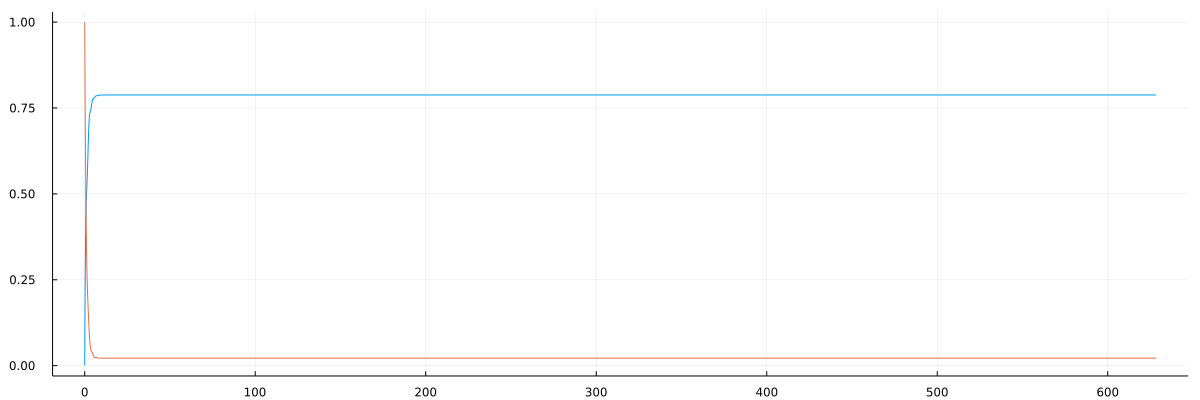

In [835]:
plot(sol.t, [real(u[1,1]) for u in sol.u], size=(1200, 400))
plot!(sol.t, [real(u[2,2]) for u in sol.u], legend=false)

In [836]:
real.(mean(sol.u[end-3000:end]))

4×4 Matrix{Float64}:
  0.787997     -6.17406e-5  -0.000173178   2.08858e-5
 -6.17406e-5    0.0217867    2.59026e-5   -2.98945e-6
 -0.000173178   2.59026e-5   0.187263     -8.19969e-6
  2.08858e-5   -2.98945e-6  -8.19969e-6    0.0029535

In [777]:
function chunk_time(v, t_max, deltat_v)
    chunk_time = 0.0
    if iszero(v)
        chunk_time = t_max
    else
        chunk_time = minimum((2π * deltat_v / abs(v), t_max))
    end
    return chunk_time
end

chunk_time (generic function with 1 method)

In [778]:
function calculate_force(p, sol)
    force = 0.0
    for i in 1:length(sol.t)
        force += OpticalBlochEquations.force(p, sol.u[i], sol.t[i])
    end
    return force / length(sol.t)
end

calculate_force (generic function with 1 method)

In [779]:
function calculate_force_dense(times, p, sol)
    force = 0.0
    for t in times
#         force += real(sol.u[i][1,1]) / 5000
        force += OpticalBlochEquations.force(p, sol(t), t)
    end
#     return mean(real(u[2,2]) for u in sol.u)
    return force / length(sol.t)
end

calculate_force_dense (generic function with 1 method)

In [780]:
t_max = 2π * 100
max_iters = 10
reltol = 1e-3
;

In [781]:
vs = -5:0.125:5.0
# rounded_vs = [round_vel(v, λ, Γ, freq_res) for v in vs]
forces = zeros(length(vs))

@time begin
#     Threads.@threads for i in 1:length(vs)
    for i in 1:length(vs)
        
        v = vs[i]
        
        delta_t = chunk_time(v, t_max, 4)
#         println(delta_t)
        
        previous_force = 0.0
        force = 1.0
        error = 1.0
        
        p_ = deepcopy(p)
        
        p_.particle.r = SVector(0, 0, 0)
        p_.particle.v = SVector(0, 0, v)
         
        ρ0 = zeros(ComplexF64, (4,4))
        ρ0[1,1] = 0.5
        ρ0[2,2] = 0.5
        
        j = 0
        
        while (error > reltol) && (j < max_iters)
               
            tspan = (delta_t * j, delta_t * (j + 1))
            times = range(tspan[1], tspan[2], 5000)

            prob = ODEProblem(ρ!, ρ0, tspan, p_)
#             sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, save_everystep=true)
            sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, saveat=times)
#             sol = solve(prob, alg=OwrenZen5(), abstol=1e-6, reltol=1e-3, dense=true)
            
            previous_force = force
            force = calculate_force(p_, sol)
#             force = calculate_force_dense(times, p_, sol)
            
            j += 1
            error = ((previous_force - force) / force)^2
            
        end

#         println(v, real.(sol.u[end]))
#         println(error, ' ', j)
        forces[i] = force
            
    end
end

  0.574296 seconds (966.35 k allocations: 315.834 MiB, 8.72% gc time, 3.16% compilation time)


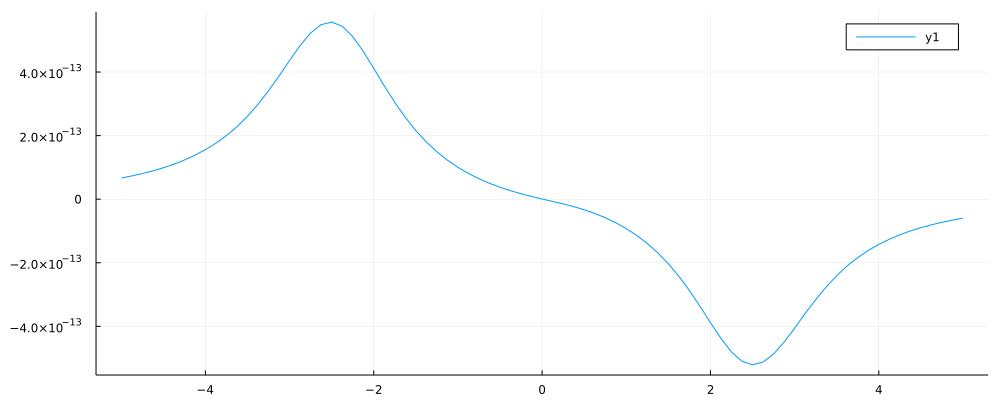

In [782]:
plot(vs, real.(forces), size=(1000,400))

In [783]:
@btime ρ!($dρ, $ρ, $p, $1.0)

  533.158 ns (0 allocations: 0 bytes)
